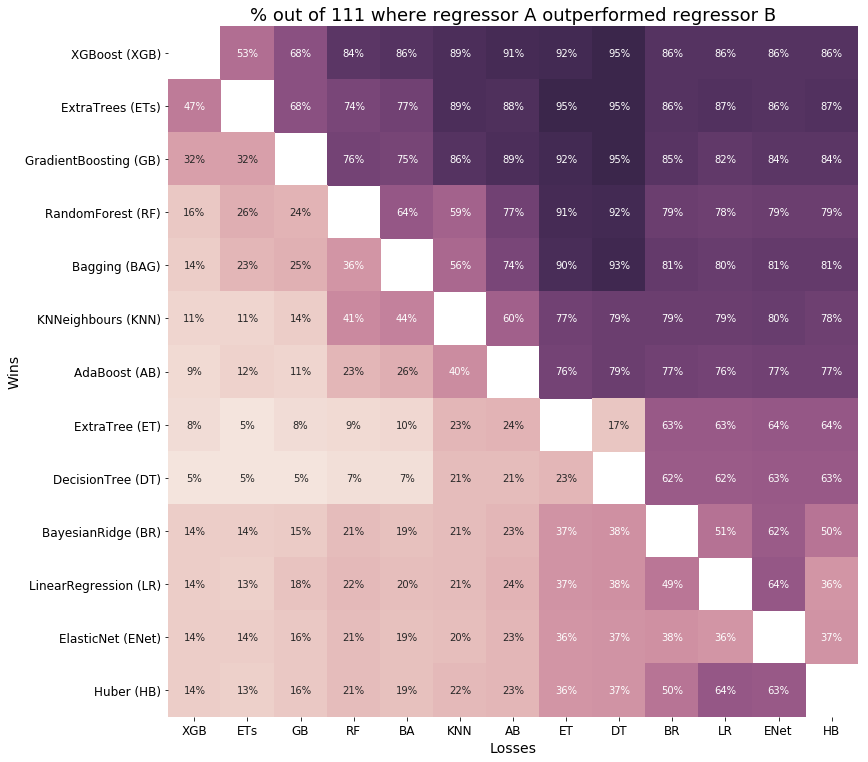

Total time taken: 7 seconds


In [44]:
import sys
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
import os
import numpy as np
import warnings
import seaborn as sb
import operator

import plotly
import plotly.graph_objs as go
from plotly import tools
import plotly.io as pio


warnings.filterwarnings('ignore')

start_time = time.time()
folder_name = "european_days/"
clf_names_dir = os.listdir(folder_name)

def check_file(f_name):
    for clf in clf_names_dir:
        data_path = folder_name + clf
        files = [f for f in os.listdir(data_path)]
        if f_name not in files:
            return False
            break
    return True

clf_names = list()
r2_dict = dict()
clf_sum_r2 = dict()

for clf in clf_names_dir:
    data_path = folder_name + clf
    files = [f for f in os.listdir(data_path)]
    r2_scores = list()
    r2_dict[clf] = list()
    for f_name in files:
        if_file_present = check_file(f_name)
        if if_file_present is True:
            f_path = data_path + "/" + f_name
            df = pd.read_csv(f_path, sep="\t")
            rank_test_score = df[df["rank_test_score"] == 1]
            mean_test_score = rank_test_score["mean_test_score"]
            r2_scores.append(mean_test_score.iloc[0])
    r2_dict[clf] = r2_scores
    clf_sum_r2[clf] = np.sum(r2_scores)
    clf_names.append(clf)
    
n_clf = len(clf_names)

sorted_clf = sorted(clf_sum_r2.items(), key=lambda kv: kv[1], reverse=True)
clf_sorted = [a[0] for a in sorted_clf]

model_nice_dict = {
    'XGBoost': 'XGB',
    'ExtraTrees': 'ETs',
    'GradientBoosting': 'GB',
    'RandomForest': 'RF',
    'Bagging': 'BA',
    'KNNeighbours': 'KNN',
    'AdaBoost': 'AB',
    'ExtraTree': 'ET',
    'DecisionTree': 'DT',
    'BayesianRidge': 'BR',
    'LinearRegression': 'LR',
    #'LinearSVR': 'LSVR',
    #'Lars': 'LA',
    'ElasticNet': 'ENet',
    #'SGD': 'SGD',
    'Huber': 'HB'
}

model_nice_dict_y = {
    'XGBoost': 'XGBoost (XGB)',
    'ExtraTrees': 'ExtraTrees (ETs)',
    'GradientBoosting': 'GradientBoosting (GB)',
    'RandomForest': 'RandomForest (RF)',
    'Bagging': 'Bagging (BAG)',
    'KNNeighbours': 'KNNeighbours (KNN)',
    'AdaBoost': 'AdaBoost (AB)',
    'ExtraTree': 'ExtraTree (ET)',
    'DecisionTree': 'DecisionTree (DT)',
    'BayesianRidge': 'BayesianRidge (BR)',
    'LinearRegression': 'LinearRegression (LR)',
    #'LinearSVR': 'LinearSVR (LSVR)',
    #'Lars': 'Lars (LA)',
    'ElasticNet': 'ElasticNet (ENet)',
    #'SGD': 'SGD',
    'Huber': 'Huber (HB)'
}

x_labels = list(model_nice_dict.values())
y_labels = list(model_nice_dict_y.values())

# plot heatmap
performance_datasets = np.zeros(shape=(n_clf,n_clf), dtype=float)

for x, clf_x in enumerate(clf_sorted):
    for y, clf_y in enumerate(clf_sorted):
        x_perf = r2_dict[clf_x]
        y_perf = r2_dict[clf_y]
        n_datasets = len(r2_dict[clf_x])
        x_g_y = len([1 for (a,b) in zip(x_perf, y_perf) if a > b]) / float(n_datasets)
        y_g_x = len([1 for (a,b) in zip(x_perf, y_perf) if b > a]) / float(n_datasets)
        performance_datasets[x][y] = x_g_y
        performance_datasets[y][x] = y_g_x

mask_matrix = []
for x in range(n_clf):
    for y in range(n_clf):
        mask_matrix.append(x == y)
mask_matrix = np.array(mask_matrix).reshape(n_clf, n_clf)

rcParams['font.family'] = "Times New Roman"

plt.figure(figsize=(12, 12))
sb.heatmap(np.round((performance_datasets), 2), fmt='0.0%',
           mask=mask_matrix,
           cmap=sb.cubehelix_palette(500, light=0.95, dark=0.15),
           square=True, annot=True, vmin=0., vmax=1.0,
           xticklabels=x_labels, yticklabels=y_labels, cbar=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Losses', fontsize=14)
plt.ylabel('Wins', fontsize=14)
plt.title('% out of '+ str(n_datasets) +' where regressor A outperformed regressor B', fontsize=18)
h = plt.gcf()
plt.tight_layout()
plt.show()

# plot average performance on datasets


end_time = time.time()
print('Total time taken: %d seconds' % int(end_time - start_time))


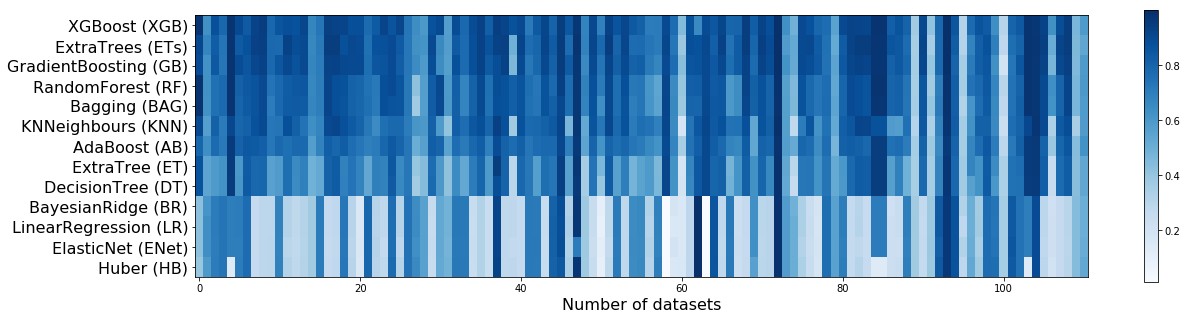

In [84]:
# plot r2-clf matrix
r2_clf_matrix = np.zeros(shape=(n_clf, n_datasets), dtype=float)
plt.figure(figsize=(20, 20))

for x, clf in enumerate(clf_sorted):
    r2_clf_matrix[x] = r2_dict[clf]

plt.xlabel('Number of datasets', size=16)
plt.yticks(range(n_clf), y_labels, size=16)
plt.imshow(r2_clf_matrix, cmap='Blues', aspect=2.5)
plt.colorbar(shrink=0.25)
plt.show()

Processing results for optimisation ...
Processing results for no optimisation ...


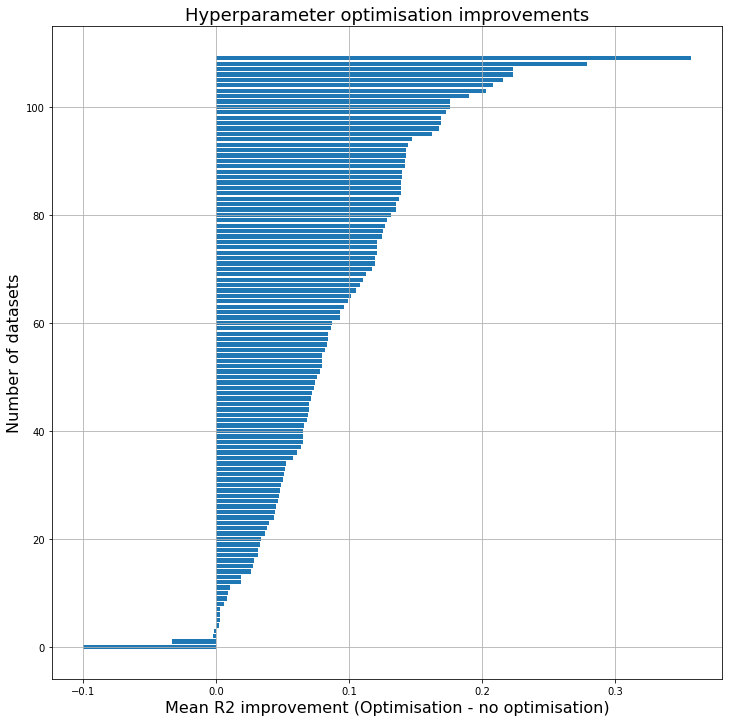

In [85]:
folder_name_tuning = "tuning/"
folder_name_no_tuning = "no_tuning/"
clf_names_dir_tuning = os.listdir(folder_name_tuning)
clf_names_dir_no_tuning = os.listdir(folder_name_no_tuning)

file_obj = open("file_names.txt", "r")
dataset_names = file_obj.read()
dataset_names = dataset_names.split("\n")

clf_names_tuning = list()
clf_mean_r2_tuning = list()
r2_dict_tuning = dict()
fit_time_dict_tuning = dict()

print("Processing results for optimisation ...")

for clf in clf_names_dir_tuning:
    data_path = folder_name_tuning + clf
    files = [f for f in os.listdir(data_path)]
    r2_scores = list()
    common_fileset = list()
    for f_name in files:
        if f_name in dataset_names: 
            common_fileset.append(f_name)
            f_path = data_path + "/" + f_name
            df = pd.read_csv(f_path, sep="\t")
            rank_test_score = df[df["rank_test_score"] == 1]
            mean_test_score = rank_test_score["mean_test_score"]
            r2_scores.append(mean_test_score.iloc[0])
    clf_names_tuning.append(clf)
    r2_dict_tuning[clf] = r2_scores
    #print("Mean R2 score for %s regressor: %s" % (clf, np.mean(r2_scores)))

clf_names_no_tuning = list()
clf_mean_r2_no_tuning = list()
r2_dict_no_tuning = dict()
fit_time_dict_no_tuning = dict()

print("Processing results for no optimisation ...")

for clf in clf_names_dir_no_tuning:
    data_path = folder_name_no_tuning + clf
    files = [f for f in os.listdir(data_path)]
    r2_scores = list()
    for f_name in files:
        if f_name in dataset_names:
            f_path = data_path + "/" + f_name
            df = pd.read_csv(f_path, sep="\t")
            rank_test_score = df[df["rank_test_score"] == 1]
            mean_test_score = rank_test_score["mean_test_score"]
            r2_scores.append(mean_test_score.iloc[0])
    clf_names_no_tuning.append(clf)
    r2_dict_no_tuning[clf] = r2_scores
    #print("Mean R2 score for %s regressor: %s" % (clf, np.mean(r2_scores)))

n_datasets = len(common_fileset)
n_clf = len(clf_names_no_tuning)
clf_datasets_perf = np.zeros(shape=(n_clf, n_datasets), dtype=float)

for x, clf in enumerate(clf_names_no_tuning):
    tuning_perf = r2_dict_tuning[clf]
    no_tuning_perf = r2_dict_no_tuning[clf]
    diff = [(a-b) for a,b in zip(tuning_perf, no_tuning_perf)]
    clf_datasets_perf[x] = diff

mean_perf_datasets = np.mean(clf_datasets_perf, axis=0)

plt.figure(figsize=(12, 12))
y_pos = np.arange(n_datasets)
plt.barh(y_pos, sorted(mean_perf_datasets))
plt.xlabel('Mean R2 improvement (Optimisation - no optimisation)', size=16)
plt.ylabel('Number of datasets', size=16)
plt.title('Hyperparameter optimisation improvements', size=18)
plt.grid(True)
plt.show()
